In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import time
import math

from numpy import array
from numpy.random import seed
from matplotlib import pyplot

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, GRU
from keras.layers import concatenate

from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm

from keras import optimizers
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.utils import check_array

Using TensorFlow backend.


# Collect the data from .CSV file

Once we have collected a nice dataset where labels and streams are connected, we are in a position to figure out how to extract valuable information from them and even create predictive models.

In [2]:
vocabulary = pd.read_csv('input/vocabulary.csv')
vocabulary = pd.DataFrame(vocabulary['Name'])

videos_df = pd.read_csv('yt8m_data.csv')
videos_df_2 = pd.read_csv('yt8m_data-2.csv')
videos_df_3 = pd.read_csv('yt8m_data-3.csv')

videos_df = pd.concat([videos_df, videos_df_2],ignore_index=True)
videos_df = pd.concat([videos_df, videos_df_3],ignore_index=True)

In [3]:
display(videos_df.tail())
videos_df.describe()

,Unnamed: 0,creator,duration,id,labels,ladder,title,views
3060,1016,NaN,244.0,Zvbw963V5bQ,"[31, 40, 47]","[{'160 - 244x144 (DASH video)': 108.0}, {'133 ...",Coldplay Sparks on piano with GloKeys,1221.0
3061,1017,NaN,276.0,Zw-wymfA3eM,"[2, 30, 55]","[{'160 - 256x144 (144p)': 111.057}, {'133 - 42...",125er Saisonstart 2015 NRW | YoungRider125cc,42647.0
3062,1018,NaN,338.0,ZzUohnlCjyU,"[0, 1, 5, 928]","[{'160 - 192x144 (144p)': 123.503}, {'133 - 32...",todos los personajes de mario bros nuestra inf...,7699.0
3063,1019,Jimmy Eat World,232.0,_0BPYA8bzWw,"[25, 2313]","[{'160 - 192x144 (144p)': 84.642}, {'133 - 320...",Stargate fun!,2513.0
3064,1020,NaN,173.0,636t-Y2Kgak,"[2, 7, 95, 179, 252]","[{'160 - 192x144 (144p)': 110.844}, {'133 - 32...",suzuki ignis 4x4 new edition (2^ parte),11184.0


,Unnamed: 0,duration,views
count,3065.000000,3065.000000,3.065000e+03
mean,510.349429,254.280914,6.054143e+04
std,295.005645,99.548680,4.924978e+05
min,0.000000,119.000000,1.011000e+03
25%,255.000000,173.000000,2.206000e+03
50%,510.000000,234.000000,5.015000e+03
75%,766.000000,315.000000,1.580400e+04
max,1028.000000,501.000000,1.527585e+07


In [4]:
display(vocabulary.head())
vocabulary.shape

,Name
0,Game
1,Video game
2,Vehicle
3,Concert
4,Musician


(3862, 1)

## Prepare the output ladders

In [5]:
ladder_array = []
resolutions = [144,240,360,480,720,1080]
#resolutions = [480,720,1080]

# Extract the ladders from the data frame to create the output layer
for video in videos_df['ladder']:
    ladder = {}
    video = video.replace('[','')
    video = video.replace(']','')
    video = video.replace('}','')
    data = np.array(video.split(','))

    for step in data:
        try:
            resolution = int(step.split('x')[1].split(' ')[0])
            bitrate = float(step.split(':')[1])

            if (resolution in resolutions):
                ladder[resolution] = bitrate
        except:
            print('There was an error')
    ladder_array.append(ladder)
# Create a new dataframe with the coresponding ladders
ladders_df = pd.DataFrame(ladder_array)

# Remove the rows of the input data frame with non relevant data to avoid bias in the predictions
# These are basically those entries where not all the resolutions have a value.
display(ladders_df.describe())
print("Prior to dropna")
videos_df = videos_df.drop('Unnamed: 0', axis = 1)
videos_df = videos_df.fillna(0)
videos_df = pd.concat([videos_df, ladders_df], axis=1)
videos_df = videos_df.dropna()

# Remove also thos rows from the output
ladders_df = ladders_df.dropna()
ladders_df = ladders_df.fillna(0)

# Print the relevant statistics before the scaling
display(ladders_df.describe())
print("After dropna")
display(ladders_df)
print("Prior to scaling")

# Scale the output
scaler_output = MinMaxScaler(feature_range=(0,1)).fit(ladders_df.values)
ladders_values = scaler_output.transform(ladders_df.values)
ladders_df = pd.DataFrame(ladders_values,
                          columns=resolutions)

display(ladders_df)

print("After scaling")

There was an error


,144,240,360,480,720,1080
count,2934.000000,2877.000000,2586.000000,2371.000000,1446.000000,613.000000
mean,113.088060,249.512905,529.776716,1022.954134,2111.720156,4054.863305
std,12.895496,22.434632,152.052850,215.820715,509.026852,982.122269
min,29.296000,50.782000,39.234000,63.441000,104.165000,296.000000
25%,110.454500,246.157000,455.387250,984.237500,2055.631000,4031.785000
50%,112.606000,248.601000,605.059000,1114.253000,2223.431000,4185.881000
75%,115.459250,253.036000,610.309750,1155.000000,2296.754000,4331.250000
max,271.238000,465.114000,3687.987000,3700.576000,5530.929000,6923.248000


Prior to dropna


,144,240,360,480,720,1080
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,112.139182,249.667894,552.017782,1040.944796,2094.073726,4046.679792
std,7.942346,22.222195,180.983106,207.885498,488.911127,980.582740
min,44.011000,85.723000,62.853000,101.575000,176.150000,296.000000
25%,110.388000,246.206000,502.937000,1102.199000,2045.852000,4028.441000
50%,111.822000,248.738000,606.674000,1115.158000,2225.716000,4181.220000
75%,114.400500,253.486000,612.569500,1155.000000,2310.000000,4331.250000
max,166.731000,366.545000,3687.987000,2460.943000,3497.727000,6902.853000


After dropna


,144,240,360,480,720,1080
5,114.595,252.184,415.080,907.909,2041.606,6902.853
15,109.656,248.629,606.433,1108.048,2222.436,4156.889
23,112.922,254.094,606.459,1111.571,2245.235,4156.952
27,121.129,259.802,410.134,791.269,1405.160,3042.019
30,112.620,251.179,616.550,1125.195,3378.174,5551.100
34,112.380,245.717,314.265,649.971,1292.294,2696.197
37,108.000,242.000,606.074,1155.000,2310.000,4331.250
47,112.788,249.641,607.835,1126.660,2228.082,4190.650
48,111.233,248.354,609.723,1113.695,3325.586,5529.911
55,110.694,256.877,604.290,1111.531,2210.941,4127.486


Prior to scaling


,144,240,360,480,720,1080
0,0.575163,0.592763,0.097162,0.341758,0.561618,1.000000
1,0.534917,0.580104,0.149948,0.426586,0.616059,0.584376
2,0.561530,0.599565,0.149955,0.428079,0.622922,0.584386
3,0.628406,0.619891,0.095798,0.292322,0.370008,0.415632
4,0.559069,0.589185,0.152738,0.433853,0.964007,0.795401
5,0.557114,0.569735,0.069352,0.232433,0.336028,0.363289
6,0.521423,0.556498,0.149849,0.446486,0.642421,0.610767
7,0.560438,0.583708,0.150334,0.434474,0.617758,0.589486
8,0.547767,0.579125,0.150855,0.428979,0.948175,0.792194
9,0.543375,0.609475,0.149356,0.428062,0.612598,0.579926


After scaling


In [6]:
# Display the most relevant statistics
display(videos_df.describe())
# Check out the final aspect of the videos dataframe
display(videos_df)

,duration,views,144,240,360,480,720,1080
count,583.000000,5.830000e+02,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,255.030875,9.882127e+04,112.139182,249.667894,552.017782,1040.944796,2094.073726,4046.679792
std,103.530674,7.836398e+05,7.942346,22.222195,180.983106,207.885498,488.911127,980.582740
min,119.000000,1.030000e+03,44.011000,85.723000,62.853000,101.575000,176.150000,296.000000
25%,171.500000,2.372500e+03,110.388000,246.206000,502.937000,1102.199000,2045.852000,4028.441000
50%,231.000000,6.401000e+03,111.822000,248.738000,606.674000,1115.158000,2225.716000,4181.220000
75%,317.500000,2.077700e+04,114.400500,253.486000,612.569500,1155.000000,2310.000000,4331.250000
max,499.000000,1.527585e+07,166.731000,366.545000,3687.987000,2460.943000,3497.727000,6902.853000


,creator,duration,id,labels,ladder,title,views,144,240,360,480,720,1080
5,0,145.0,-j989rqetQE,"[4, 9, 10, 37, 1523]","[{'160 - 256x144 (144p)': 114.595}, {'133 - 42...",Blues Guitar Epiphone Riviera!!! (slide playi...,2452.0,114.595,252.184,415.080,907.909,2041.606,6902.853
15,0,485.0,wo-Rbbuy8rk,"[2, 7, 83, 208, 262, 1134]","[{'160 - 256x144 (144p)': 109.656}, {'133 - 42...",CAT D6K LGP at Zielger,6820.0,109.656,248.629,606.433,1108.048,2222.436,4156.889
23,0,248.0,FKYxkx1vajM,[3],"[{'160 - 256x144 (144p)': 112.922}, {'133 - 42...",KRISTAL MEMBURU IMPIAN AKUSTIK,3673.0,112.922,254.094,606.459,1111.571,2245.235,4156.952
27,0,147.0,jarWs1a-drU,[8],"[{'160 - 256x144 (144p)': 121.129}, {'133 - 42...",Robin vs Karton | 1/8 | SMART SESSION 2012,2403.0,121.129,259.802,410.134,791.269,1405.160,3042.019
30,0,120.0,GS4tuyum1FU,"[0, 1, 124, 153, 317]","[{'160 - 230x144 (144p)': 112.62}, {'133 - 384...",End of Round Screen Glitch Looks Awesome,1689.0,112.620,251.179,616.550,1125.195,3378.174,5551.100
34,0,154.0,WVn8ckzvdOk,"[31, 40, 47, 57]","[{'160 - 256x144 (144p)': 112.38}, {'133 - 426...",Shot at the Night by The Killers-Piano Cover,10638.0,112.380,245.717,314.265,649.971,1292.294,2696.197
37,0,383.0,WborWpqHw8E,"[4, 13, 164]","[{'160 - 256x144 (DASH video)': 108.0}, {'133 ...",Baker Marching Band Halftime Show 2013 against...,1534.0,108.000,242.000,606.074,1155.000,2310.000,4331.250
47,Mr. Probz,381.0,XgcuOXhDKWs,[284],"[{'160 - 256x144 (144p)': 112.788}, {'133 - 42...",TUFFI BERGEGGI GOPRO,6159.0,112.788,249.641,607.835,1126.660,2228.082,4190.650
48,0,276.0,3Nb2ZTNKZuE,"[0, 1, 35, 85]","[{'160 - 256x144 (144p)': 111.233}, {'133 - 42...",GTA5 Online - Ep 4 - JaltoidGames!,13758.0,111.233,248.354,609.723,1113.695,3325.586,5529.911
55,0,166.0,eJoDnjilW74,[25],"[{'160 - 256x144 (144p)': 110.694}, {'133 - 42...",300: Vzestup říše (2014) CZ HD trailer č.2,9837.0,110.694,256.877,604.290,1111.531,2210.941,4127.486


## Prepare categorical data to make embeddings

In the _labels_ colum from the videos_df DataFrame we can observe that label data from YT8M dataset comes as arrays of different lengths. We need to homogeneize them in order to pass them to Keras' embedding layer. The parameter max_length has been set to 15 in a somewhat arbitrary manner just to make sure that all videos fit.

In [7]:
labels_array = []
# The parameter max_length has been set to 15 in a somewhat arbitrary manner just to make sure that all videos fit.
max_labels_length = 14
for video in videos_df['labels']:
    video = video.replace('[','')
    video = video.replace(']','')
    data = np.array(video.split(','),dtype='int')

    if len(data) < max_labels_length:
        extension = np.zeros(max_labels_length - len(data))
        data = np.concatenate((data, extension), axis=0)
        
    labels_array.append(data)

labels_df = pd.DataFrame(labels_array,dtype='int32').dropna()

display(labels_df.head())
labels_df.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,4,9,10,37,1523,0,0,0,0,0,0,0,0,0
1,2,7,83,208,262,1134,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,124,153,317,0,0,0,0,0,0,0,0,0


(583, 14)

## Normalize the continuous inputs

In [8]:
# Scale the input
scaler_input = MinMaxScaler(feature_range=(0,1)).fit(videos_df[['duration', 'views']].values)
videos_values = scaler_input.transform(videos_df[['duration', 'views']].values)
input_videos_df = pd.DataFrame(videos_values, columns=['duration', 'views'])

## Assemble a Keras model

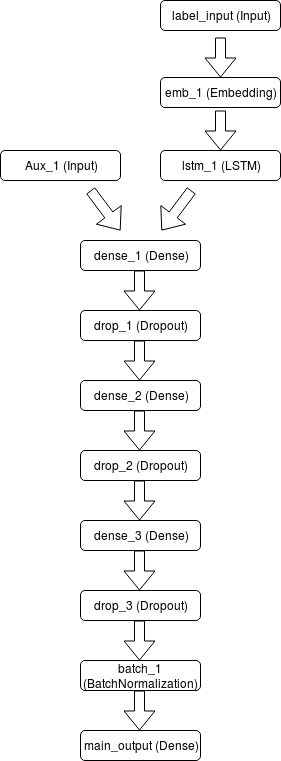

This defines a model with two inputs and two outputs:

In [9]:
# Label input: meant to receive sequences of max_labels_length integers, between 1 and 3862.

label_input = Input(shape=(max_labels_length,), dtype='float32', name='label_input')

# This embedding layer will encode the input sequence
# into a sequence of dense max_labels_length-dimensional vectors.
x = Embedding(output_dim=max_labels_length, input_dim=len(vocabulary), input_length=max_labels_length, name='emb_1')(label_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
dense_out = Dense(32, activation='relu', name='dense_0')(x)
gru_out = LSTM(16)(x)


At this point, we feed into the model our auxiliary input data by concatenating it with the LSTM output:

In [10]:
auxiliary_input = Input(shape=(input_videos_df.shape[1],), dtype='float32', name='aux_input')
x = concatenate([gru_out, auxiliary_input])
# We stack a deep densely-connected network on top
x = Dense(64, kernel_initializer='lecun_uniform', activation='tanh', name='dense_1')(x)
x = Dropout(0.5, name='drop_1')(x)
x = Dense(16, kernel_initializer='lecun_uniform', activation='tanh', name='dense_2')(x)
x = Dropout(0.4, name='drop_2')(x)
x = Dense(8, kernel_initializer='lecun_uniform', activation='tanh', name='dense_3')(x)
x = Dropout(0.2, name='drop_3')(x)

# And finally we add the main output layer
main_output = Dense(len(resolutions), activation='relu', name='main_output')(x)

In [11]:
model = Model(inputs=[label_input, auxiliary_input], outputs=[main_output])

We can train the model by passing it lists of input arrays and target arrays:

In [12]:
#Split into test and train sets
train_items = int(len(videos_df)*0.8)

train_videos_df = input_videos_df.iloc[:train_items, :]
train_labels_df = labels_df.iloc[:train_items, :]
train_Y = ladders_df.iloc[:train_items, :]

test_videos_df = input_videos_df.iloc[train_items:, :]
test_labels_df = labels_df.iloc[train_items:, :]
test_Y = ladders_df.iloc[train_items:, :]

validate_videos_df = input_videos_df.tail(1)
validate_labels_df = labels_df.tail(1)

print('TOTAL SIZE OF DATASET:', int(len(videos_df)))
print("TOTAL TRAIN ITEMS:" ,int(len(train_Y)))
print('TOTAL TEST ITEMS:', int(len(test_Y)))

TOTAL SIZE OF DATASET: 583
TOTAL TRAIN ITEMS: 466
TOTAL TEST ITEMS: 117


In [13]:
import keras.backend as K
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [14]:
# We compile the model and assign a weight of 0.2 to the auxiliary loss. 
# Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.
adam = optimizers.adam(lr=0.001, beta_1=0.8, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=True)
model.compile(optimizer='adam',
              loss={'main_output': euclidean_distance_loss},
              loss_weights={'main_output': 0.5}
              )

start_time = time.time()
epochs_var = 5000
# Early stopping  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=epochs_var*0.1, verbose=1, mode='auto')


# And trained it via:
history = model.fit({'label_input': train_labels_df.values, 'aux_input': train_videos_df.values},
                    {'main_output': train_Y.values},
                    validation_data=({'label_input': test_labels_df.values, 'aux_input': test_videos_df.values},
                    {'main_output': test_Y.values}),
                    epochs= epochs_var,
                    batch_size=int(len(train_Y)*0.6),
                    verbose=0,
                   callbacks=[early_stop])

elapsed_time = time.time() - start_time

print("Training done in ", elapsed_time, " s")

Epoch 00633: early stopping
Training done in  13.702876329421997  s


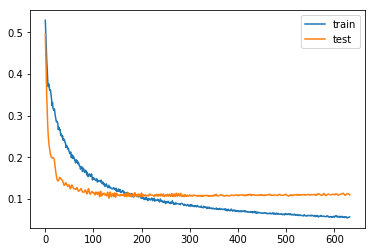

0.46592332665756536

In [15]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
display(history.history['loss'][len(history.history)])

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
index= 578

display(test_labels_df.loc[index].values)
prediction = model.predict({'label_input': test_labels_df.values, 'aux_input': test_videos_df.values})

prediction_df = pd.DataFrame(prediction)
#invert the normalization to bring it back to its original units
prediction_df = pd.DataFrame(scaler_output.inverse_transform(prediction_df.values),
                         columns=test_Y.columns,
                         index = test_Y.index)
display(prediction_df.loc[index])
print("Prediction")

test_Y_df = pd.DataFrame(scaler_output.inverse_transform(test_Y.values),
                         columns=test_Y.columns,
                         index = test_Y.index)

display(test_Y_df.loc[[index]])
print("Test")
y_true = test_Y_df.loc[[index]].values
y_pred = prediction_df.loc[[index]].values
print('MAPE:', mean_absolute_percentage_error(y_true, y_pred), '%')
display(videos_df.iloc[index])
print("YouTube ID: https://www.youtube.com/watch?v=" + videos_df['id'].iloc[index])
display(labels_df.iloc[[index]])
print("Labels")
for label in labels_df.iloc[index].values:
    if label != 0:
        display(vocabulary.loc[label].values)
display(ladders_df.describe())

array([   2,    7,   48,   90,  165,  373,  415, 2559,    0,    0,    0,
          0,    0,    0], dtype=int32)

144      106.484993
240      234.141083
360      504.455566
480     1008.262756
720     1937.326416
1080    3684.433105
Name: 578, dtype: float32

Prediction


,144,240,360,480,720,1080
578,117.509,264.497,604.887,1106.856,2214.732,4139.203


Test
MAPE: 11.64691158372617 %


creator                                                     0
duration                                                  221
id                                                J7zg44eVOys
labels                    [2, 7, 48, 90, 165, 373, 415, 2559]
ladder      [{'160 - 256x144 (144p)': 117.509}, {'133 - 42...
title                  132959 / 1995 Ford Saleen Mustang S351
views                                                   32275
144                                                   117.509
240                                                   264.497
360                                                   604.887
480                                                   1106.86
720                                                   2214.73
1080                                                   4139.2
Name: 3047, dtype: object

YouTube ID: https://www.youtube.com/watch?v=J7zg44eVOys


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
578,2,7,48,90,165,373,415,2559,0,0,0,0,0,0


Labels


array(['Vehicle'], dtype=object)

array(['Car'], dtype=object)

array(['Sports car'], dtype=object)

array(['Festival'], dtype=object)

array([nan], dtype=object)

array(['Light'], dtype=object)

array(['River'], dtype=object)

array(['Need for Speed: Underground'], dtype=object)

,144,240,360,480,720,1080
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,0.555151,0.583804,0.134937,0.398145,0.577414,0.567695
std,0.064719,0.079133,0.049925,0.088111,0.147192,0.148419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.540882,0.571476,0.121398,0.424107,0.562896,0.564935
50%,0.552567,0.580492,0.150014,0.429599,0.617046,0.588059
75%,0.573578,0.597400,0.151640,0.446486,0.642421,0.610767
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
prediction_df.describe()

,144,240,360,480,720,1080
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,112.169983,250.535828,571.535339,1067.502930,2105.599365,3986.176025
std,1.694392,5.032052,71.454224,120.330101,308.022095,540.705933
min,106.484993,234.141083,284.334473,553.000305,796.855530,1692.396484
25%,111.555489,248.550079,557.247559,1050.089111,2059.814453,3905.190430
50%,112.165428,250.363220,593.033264,1104.697754,2202.256104,4158.000977
75%,112.606224,251.499496,605.180664,1125.151367,2254.979736,4248.091309
max,118.310440,268.338593,751.347595,1369.874146,2881.476074,5347.591797


In [19]:
prediction_df

,144,240,360,480,720,1080
466,111.105530,247.045258,597.240601,1121.771729,2241.129395,4222.656738
467,115.794609,263.864868,362.872894,674.981079,1112.264404,2248.057617
468,112.082001,250.244583,574.127014,1072.775513,2118.674316,4009.176758
469,112.395607,250.942154,603.671570,1119.358765,2238.160645,4219.505371
470,114.460121,260.822693,284.334473,553.000305,796.855530,1692.396484
471,110.318222,244.767349,589.073120,1115.492065,2223.025391,4189.562012
472,111.852974,249.887665,542.571838,1021.326111,1986.407349,3776.738037
473,112.330772,250.509644,618.077698,1145.256348,2304.778564,4336.286621
474,110.089561,243.847977,609.583740,1152.742432,2317.450684,4355.219238
475,111.557732,248.833023,561.286499,1055.775024,2073.459473,3929.052490
